**Проект посвящён созданию и обучению сверточной нейросети для классификации изображений кошек и собак. Используется предобученная модель MobileNet с тонкой настройкой на собственном датасете изображений. Данные предварительно разделены на тренировочный, валидационный и тестовый наборы, применяется аугментация изображений для повышения качества обучения.**

## 1. Установка Kaggle и загрузка API-ключа


In [4]:
!pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Скачивание и распаковка датасета


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog -p /content/dogs-vs-cats
!unzip /content/dogs-vs-cats/cat-and-dog.zip -d /content/dogs-vs-cats

## Создание структуры папок


Создаем базовую директорию для датасета

Определяем подкатегории: train, validation, test

Для каждой подкатегории создаем папки для классов 'cats' и 'dogs'

Выводим путь каждой созданной директории


In [7]:
import os

base_dir = '/content/dogs-vs-cats/dataset'
os.makedirs(base_dir, exist_ok=True)

subsets = ['train', 'validation', 'test']
classes = ['cats', 'dogs']

for subset in subsets:
    for class_name in classes:
        directory = os.path.join(base_dir, subset, class_name)
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory: {directory}")

Created directory: /content/dogs-vs-cats/dataset/train/cats
Created directory: /content/dogs-vs-cats/dataset/train/dogs
Created directory: /content/dogs-vs-cats/dataset/validation/cats
Created directory: /content/dogs-vs-cats/dataset/validation/dogs
Created directory: /content/dogs-vs-cats/dataset/test/cats
Created directory: /content/dogs-vs-cats/dataset/test/dogs


## Разделение изображений по классам и создание выборок

In [8]:
!ls /content/dogs-vs-cats
!ls /content/dogs-vs-cats/PetImages

cat-and-dog.zip  dataset  test_set  training_set
ls: cannot access '/content/dogs-vs-cats/PetImages': No such file or directory


Собираем все изображения кошек и собак из исходных папок, фильтруем только файлы .jpg с ненулевым размером, случайным образом перемешиваем их, делим на train (80%), validation (10%) и test (10%) и перемещаем в соответствующие директории dataset/{train, validation, test}/{cats, dogs}, при этом обрабатываем ошибки при перемещении файлов.

In [9]:
import os
import shutil
import random

source_training_dir = '/content/dogs-vs-cats/training_set/training_set'
source_test_dir = '/content/dogs-vs-cats/test_set/test_set'
base_dir = '/content/dogs-vs-cats/dataset'

all_files = []
for category in ['cats', 'dogs']:
    category_dir = os.path.join(source_training_dir, category)
    if os.path.exists(category_dir):
        for filename in os.listdir(category_dir):
            if filename.endswith('.jpg'):
                filepath = os.path.join(category_dir, filename)
                if os.path.getsize(filepath) > 0:
                    all_files.append((filepath, category))
for category in ['cats', 'dogs']:
    category_dir = os.path.join(source_test_dir, category)
    if os.path.exists(category_dir):
        for filename in os.listdir(category_dir):
            if filename.endswith('.jpg'):
                filepath = os.path.join(category_dir, filename)
                if os.path.getsize(filepath) > 0:
                    all_files.append((filepath, category))


random.shuffle(all_files)

train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

total_files = len(all_files)
train_count = int(total_files * train_ratio)
validation_count = int(total_files * validation_ratio)
test_count = total_files - train_count - validation_count

train_files = all_files[:train_count]
validation_files = all_files[train_count:train_count + validation_count]
test_files = all_files[train_count + validation_count:]

def move_files(file_list, subset_dir):
    for filepath, category in file_list:
        target_dir = os.path.join(base_dir, subset_dir, category)
        os.makedirs(target_dir, exist_ok=True)
        try:
            shutil.move(filepath, target_dir)
        except FileNotFoundError:
            print(f"Warning: File not found, skipping: {filepath}")
        except Exception as e:
            print(f"Error moving file {filepath}: {e}")

print("Moving training files...")
move_files(train_files, 'train')

print("Moving validation files...")
move_files(validation_files, 'validation')

print("Moving test files...")
move_files(test_files, 'test')

print("File distribution complete.")

Moving training files...
Moving validation files...
Moving test files...
File distribution complete.


## Создание генераторов изображений

Создаём генераторы изображений для обучения, валидации и теста с использованием ImageDataGenerator, масштабируем пиксели к диапазону 0-1, добавляем аугментацию для тренировочного набора (повороты, сдвиги, масштабирование, отражение), настраиваем размер изображений 150x150 и batch_size 32, и создаём потоки данных из соответствующих директорий.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/dogs-vs-cats/dataset/train'
validation_dir = '/content/dogs-vs-cats/dataset/validation'
test_dir = '/content/dogs-vs-cats/dataset/test'

image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Image generators created successfully.")

Found 8022 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.
Found 1004 images belonging to 2 classes.
Image generators created successfully.


## Обучение модели


Создаём модель на основе предобученной MobileNet без верхнего слоя, добавляем входной слой с размером 150x150x3, затем сверточную базу MobileNet, слой GlobalAveragePooling2D для уменьшения размерности признаков, полносвязный слой с 256 нейронами и ReLU, и выходной слой с 2 нейронами и softmax для классификации кошек и собак.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

# Определение параметров изображения
image_size = (150, 150)

# Загрузка предобученной модели MobileNet
conv_base = MobileNet(input_shape=image_size + (3,),
                       include_top=False,
                       weights='imagenet')

model = models.Sequential([
    Input(shape=image_size + (3,)), # Добавление входного слоя
    conv_base, # Добавление сверточной базы как слоя
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'), # Добавление полносвязного слоя
    Dense(2, activation='softmax') # Выходной слой для 2 классов
])
model.summary()

/tmp/ipython-input-4226643092.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(input_shape=image_size + (3,),


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,491,778 (13.32 MB)

 Trainable params: 3,469,890 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

Размораживаем последние 150 слоёв MobileNet для тонкой настройки, фиксируем остальные слои, компилируем модель с оптимизатором Adam (learning_rate=1e-5) и функцией потерь categorical_crossentropy, обучаем модель на тренировочном генераторе 30 эпох с валидацией и учитываем возможные неполные пакеты, после чего тонкая настройка модели завершена.

In [14]:
from tensorflow.keras.layers import BatchNormalization
unfreeze_layers = 150
conv_base.trainable = True
for layer in conv_base.layers[:-unfreeze_layers]:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
fine_tune_epochs = 30
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size + 1, # Добавляем 1 для учета возможного частичного последнего пакета
    epochs=fine_tune_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size + 1 # Добавляем 1 для учета возможного частичного последнего пакета
)

print("Модель тонкой настройки завершена.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,491,778 (13.32 MB)

 Trainable params: 3,469,890 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 307ms/step - accuracy: 0.9438 - loss: 0.1395 - val_accuracy: 0.9641 - val_loss: 0.0828
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9430 - loss: 0.1329 - val_accuracy: 0.9671 - val_loss: 0.0752
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.9540 - loss: 0.1167 - val_accuracy: 0.9691 - val_loss: 0.0741
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 217ms/step - accuracy: 0.9559 - loss: 0.1126 - val_accuracy: 0.9701 - val_loss: 0.0709
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 222ms/step - accuracy: 0.9577 - loss: 0.1081 - val_accuracy: 0.9701 - val_loss: 0.0665
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 216ms/step - accuracy: 0.9614 - loss: 0.0971 - val_accuracy: 0.9701 - val_loss: 0.0684
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.9640 - loss: 0.0917 - val_accuracy: 0.9711 - val_loss: 0.0681
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step - accuracy: 0.9674 - loss: 

Модель содержит 3,49 млн параметров, из которых 3,47 млн обучаемые. В процессе тонкой настройки на 30 эпох точность на тренировочном наборе постепенно росла с 94,4% до 98,5%, а на валидационном наборе достигла 98,0%. Функция потерь уменьшалась с 0,14 до 0,046 на валидации, что указывает на успешное обучение и хорошую способность модели к обобщению. Модель тонкой настройки завершена.

## Оценка модели на тестовом наборе

In [17]:
print("Оценка модели на тестовом наборе...")
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

print(f"Потери на тесте: {loss:.4f}")
print(f"Точность на тесте: {accuracy:.4f}")

Оценка модели на тестовом наборе...
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.9782 - loss: 0.0697
Потери на тесте: 0.0565
Точность на тесте: 0.9781


На тестовом наборе модель показала высокую точность — 97,8% при потере 0,0565, что подтверждает хорошее обобщение и способность корректно классифицировать изображения кошек и собак.

## Визуализация результатов обучения

Построим графики точности и потерь на обучающем и валидационном наборах для оценки производительности модели и выявления переобучения.

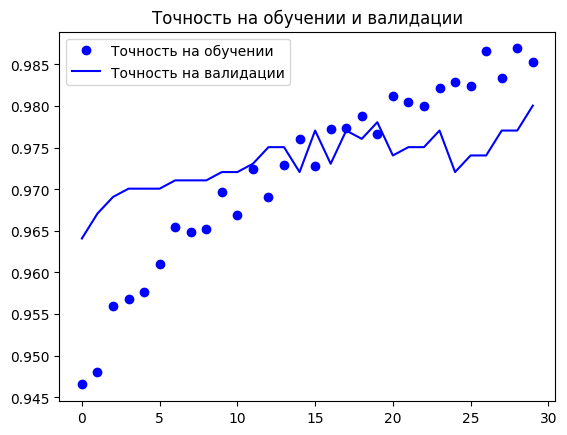

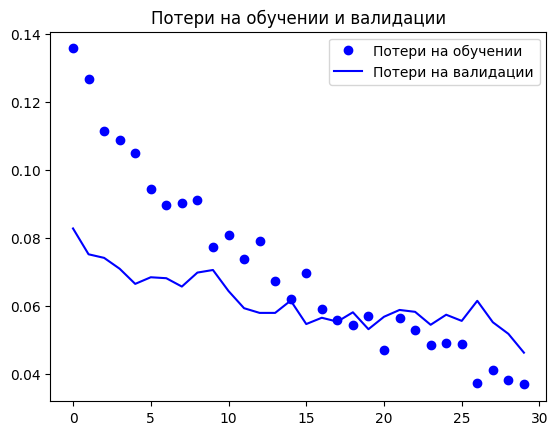

In [19]:
import matplotlib.pyplot as plt

acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']
loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Точность на обучении')
plt.plot(epochs, val_acc, 'b', label='Точность на валидации')
plt.title('Точность на обучении и валидации')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Потери на обучении')
plt.plot(epochs, val_loss, 'b', label='Потери на валидации')
plt.title('Потери на обучении и валидации')
plt.legend()

plt.show()

#Вывод

**В ходе проекта мы подготовили и структурировали датасет, реализовали генераторы изображений с аугментацией, построили модель на основе MobileNet с добавлением полносвязных слоёв, провели тонкую настройку последних слоёв сети. Модель показала высокую точность на валидационном (98,0%) и тестовом (97,8%) наборах, что свидетельствует о её высокой эффективности и способности корректно классифицировать изображения кошек и собак. Проект демонстрирует успешное применение предобученных сетей и методов аугментации для решения задачи бинарной классификации изображений.**